<a href="https://colab.research.google.com/github/demotu/gait_score/blob/main/notebooks/gps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Gait Score Neuropathy (gait_score): GPS calculation

## Python setup

In [1]:
#import libraries
import sys, os
from pathlib import Path  # file and directory paths in Python
import glob  # Unix style pathname pattern expansion
from datetime import datetime
import numpy as np  # large, multi-dimensional numeric arrays and matrices
import pandas as pd  # labelled tables with numeric and string data
import matplotlib  # data visualization
import matplotlib.pyplot as plt  # data visualization
import seaborn as sns  # data visualization
import xarray as xr  # labelled multi-dimensional arrays
from tqdm.notebook import tqdm  # progress bar
from IPython.display import display, Math, Latex  # IPython formatting
import scipy as sp  # collection of mathematical algorithms and convenience functions built on NumPy

print(f'Python {sys.version} on {sys.platform}', f' numpy {np.__version__}',
      f' scipy {sp.__version__}', f' pandas {pd.__version__}',
      datetime.now().strftime("%d/%m/%Y %H:%M:%S"), sep='\n')

Python 3.12.7 | packaged by conda-forge | (main, Oct  4 2024, 16:05:46) [GCC 13.3.0] on linux
 numpy 2.1.2
 scipy 1.14.1
 pandas 2.2.3
02/11/2024 01:09:00


In [2]:
# Environment configuration
sns.set_context('notebook', font_scale=1, rc={"lines.linewidth": 2})
sns.set_style('whitegrid')
colors = sns.color_palette()
display(colors)
style = [{'selector': 'th', 'props': [('text-align', 'left')]},
         {'selector': 'caption', 'props': [('font-weight', 'bold'), ('color', 'blue'), ('font-size', '120%')]}]
xr.set_options(keep_attrs=True)
#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', None)

variable = 'Angle'
# angle convention
planes  = ['Sagittal', 'Frontal', 'Transverse']
labels_gps = np.array(['Pelvic Tilt', 'Pelvic Obliquity', 'Pelvic Rotation',
                       'Hip Flexion', 'Hip Adduction', 'Hip Rotation',
                       'Knee Flexion', 'Ankle Dorsiflexion', 'Foot Progression', 'GPS'])

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

## Helping functions

In [3]:
def read_data(path2, fname, variable=variable):
    if os.getenv("COLAB_RELEASE_TAG"):
        url = f'https://raw.githubusercontent.com/demotu/gait_score/refs/heads/main/data/metadata_{fname}.csv'
        print(f'Loading data from {url}')
        metadata = pd.read_csv(url, sep=',', header=0, index_col=0, dtype={'Assessment':'str'})
    else:
        metadata = pd.read_csv(path2 /  f'metadata_{fname}.csv', sep=',', header=0, index_col=0, dtype={'Assessment':'str'})
    if os.getenv("COLAB_RELEASE_TAG"):
        url = f'https://github.com/demotu/gait_score/raw/refs/heads/main/data/{variable}_{fname}.nc'
        #print(f'Loading data from {url}')
        !wget {url}
        da = xr.open_dataarray(f'{variable}_{path2.name}.nc')
    else:
        da = xr.open_dataarray(path2 / f'{variable}_{fname}.nc')    
    return metadata, da


def gps_calc(da2, metadata2, labels_gps):
    """
    """
    subjects = metadata2['Subject'].unique()
    NS = subjects.size
    time = da2['Time'].values
    gvs = np.full((NS, labels_gps.size), np.nan)
    for s, subject in enumerate(subjects):
        x = da2.sel(Subject=subject).values.reshape(time.size, 9)
        gvs[s, :-1] = RMSD(x, ref_data.values)
    
    gvs[:, -1] = np.sqrt(np.mean(gvs[:, :-1]**2, axis=1))
    gvs = pd.DataFrame(data=gvs, index=subjects, columns=labels_gps)
    #gvs_m = np.sqrt(np.mean(gvs**2, axis=0))
    #gvs_std = np.sqrt(np.std(gvs**2, axis=0, ddof=1))
    gvs_m = np.percentile(gvs, 50, axis=0)
    gvs_std = np.percentile(gvs, [25, 75], axis=0)

    return gvs, gvs_m, gvs_std
    
    
def plot_gps(gvs, gvs_m, gvs_std, metadata2, path2, hist=True, MAP=True):
    """
    """
    subjects = metadata2['Subject'].unique()
    NS = subjects.size    
    if hist:
        axs = gvs.hist(layout=(2, 5), figsize=(12, 5))
        for ax in axs[:, 0]:
            ax.set_ylabel('Frequency')
        for ax in axs[1, :]:
            ax.set_xlabel('RMS difference ($^o$)')
        plt.suptitle(f'Histograms for GVS and GPS values ({NS} subjects)')
        plt.tight_layout()
        plt.show()
    if MAP:
        fig, axs = plt.subplots(1, 1, figsize=(6, 4))
        x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 11]
        axs.bar(x=x, height=gvs_m, yerr=gvs_std, width=.8, edgecolor=None, capsize=5)
        axs.set_ylabel('RMS difference ($^o$)')
        axs.set_xlabel('')
        axs.xaxis.set_ticks(x)
        axs.set_xticklabels(gvs.columns.values, rotation=45, ha='right')
        axs.grid(True)
        plt.suptitle(f'Movement analysis profile ({NS} subjects)')
        plt.tight_layout()
        plt.show()   


## The Gait Proﬁle Score (GPS)

Baker et al. (2009) proposed the Gait Proﬁle Score (GPS) as an index of overall gait pathology.  
To calculate the GPS, first the Gait Variable Score (GVS) is determined as the RMS difference between a gait variable of a subject and the average of this gait variable for a sample with no gait pathology (reference).  
The Gait Proﬁle Score (GPS) is the RMS average of all GVS values.  
The Movement Analysis Proﬁle (MAP) is a plot with all GVS values and the GPS value of the subject and of the reference sample.  
Baker et al. suggested nine angular variables of gait for using in the GPS calculation: Pelvic tilt, obliquity and rotation, Hip flexion, abduction and rotation, knee flexion, Ankle dorsiflexion and Foot progression.  
Baker et al. also suggested to calculate the GVS of the angles for both sides (left and right) with the exception of the pelvic angles, which usualy have the same values for both sides in gait analysis.

### Root mean square (RMS) and RMS deviation (RMSD)

The root mean square (RMS) of a set of values (sample) is the square root of the arithmetic mean of the squares of the sample:

$$ \mathrm{RMS} = \sqrt{ \sum_{i=1}^N \frac{x_i^2}{N} } $$

The root-mean-square deviation (RMSD) or root mean square error (RMSE) is the square root of the average of squared deviations between two sets of values (samples) $x$ and $y$ of size $N$:

$$ \mathrm{RMSD} = \sqrt{ \sum_{i=1}^N \frac{(y_i-x_i)^2}{N} } $$


In [4]:
RMSD = lambda x, y: np.sqrt(np.nanmean((y - x)**2, axis=0))  #  x and y must be arrays

### Reference data

In [5]:
# reference data from Claudiane
if os.getenv("COLAB_RELEASE_TAG"):
    url = 'https://raw.githubusercontent.com/demotu/gait_score/refs/heads/main/data/Claudiane/angles_ref_gp19b.csv'
    ref_data = pd.read_csv(url, index_col=0)
else:
    ref_data = pd.read_csv('./../data/Claudiane/angles_ref_gp19b.csv', index_col=0)

### Project ERJ

In [6]:
path2 = Path('./../data/')
metadata, da = read_data(path2, fname='ERJ_T00', variable=variable)
display(da)

<xarray.DataArray 'Angle' (Time: 51, Joint: 3, Axis: 3, Trial: 10, Subject: 105)> Size: 4MB
[481950 values with dtype=float64]
Coordinates:
  * Subject  (Subject) object 840B 'C02' 'C04' 'C06' 'C07' ... 'S68' 'S70' 'S71'
  * Time     (Time) float64 408B 0.0 2.0 4.0 6.0 8.0 ... 94.0 96.0 98.0 100.0
  * Trial    (Trial) int32 40B 0 1 2 3 4 5 6 7 8 9
  * Joint    (Joint) object 24B 'Pelvis' 'Hip' 'Knee'
  * Axis     (Axis) object 24B 'ML' 'AP' 'VT'
Attributes:
    units:    deg

#### GPS calculation

/home/marcos/miniconda3/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1650: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


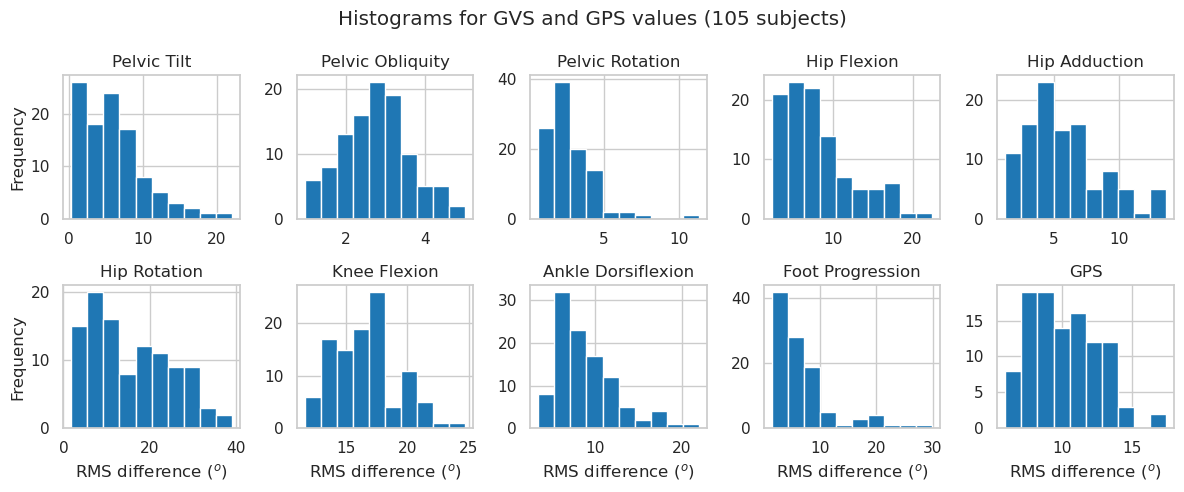

In [8]:
da2 = da.dropna(dim='Subject', how='all').reduce(np.nanquantile, q=.5, dim='Trial') #da.reduce(np.nanmean, dim='Trial')
gvs, gvs_m, gvs_std = gps_calc(da2, metadata, labels_gps)
plot_gps(gvs, gvs_m, gvs_std, metadata, path2, hist=True, MAP=False)

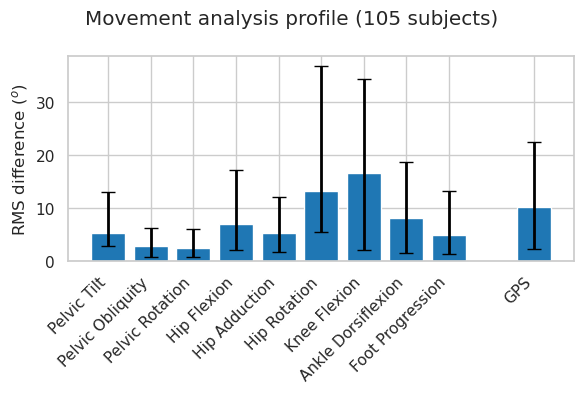

In [9]:
plot_gps(gvs, gvs_m, gvs_std, metadata, path2, hist=False, MAP=True)